<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/17_findProblemsOfSegmentation_05312023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항	|상세기준|내 평가|
|--|--|--|
|1. 인물모드 사진을 성공적으로 제작하였다.	|아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|O|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.	|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|O|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.	|semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.|O|

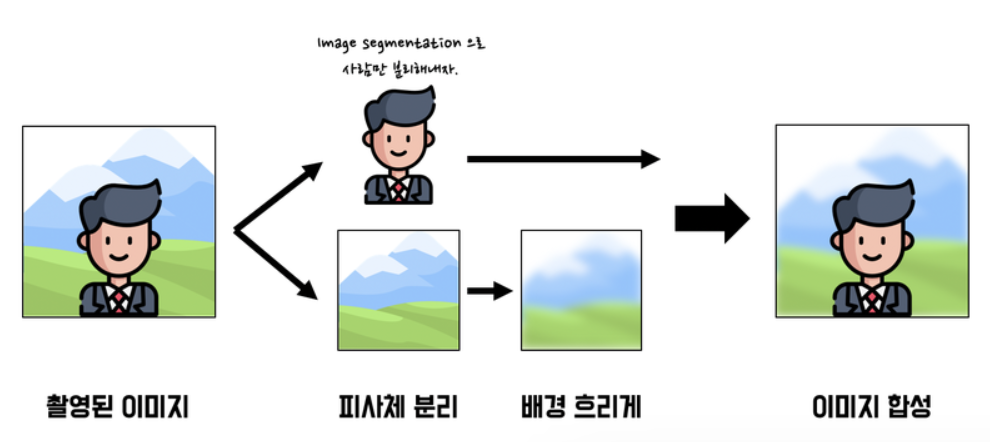

- 이미지 세그멘테이션(image segmentation) : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법  
    - 시맨틱 세그멘테이션(semantic segmentation) : 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션. 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법  
    - 인스턴스 세그멘테이션(Instance segmentation) : 사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현. 사람 개개인별로 다른 라벨을 가지게 합니다


In [ ]:
import os
import urllib  # 웹이서 데이터를 다운로드 받을 때
import cv2  #OpenCV라이브러리로 이미지를 처리하기 위해
import numpy as np
from pixellib.semantic import semantic_segmentation   # library for segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


# Load Model

In [ ]:
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [ ]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [ ]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
def segmatation(img):
    
    # load original image
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/'+ img  
    img_orig = cv2.imread(img_path) 
# print(img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title('original')
    plt.show()
    
    # segmentation
    segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
#     plt.imshow(output)
#     plt.title('segmentation')
#     plt.show()
    
    # print result of segmentaion
    for class_id in segvalues['class_ids']:
        print(' Segmentation < Object : {id}, Index : {index} >'.format(id=LABEL_NAMES[class_id], index=class_id))

    return img_orig, output 

In [ ]:
def mask(object, blur):
    # colormap to rgb
    colormap[object]
    seg_color = np.zeros((3,))
    seg_color = seg_color.astype(int)
    for i in range(3):
        idx = 2 - i
        seg_color[idx] = colormap[object][i]

    # gray scale    
    seg_map = np.all(output==seg_color, axis=-1) 
#     plt.imshow(seg_map, cmap='gray')
#     plt.title('gray')
#     plt.show()
    
    # to colormap.jet
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # blur
    img_orig_blur = cv2.blur(img_orig, (blur,blur)) # (13,13)은 차이가 없었음.
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.title('blur')
#     plt.show()
    
    # mask
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.title('masked')
#     plt.show()
    
    # focused object + blured background
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title('result')
    plt.axis('OFF')
    plt.show()
    
    return img_concat

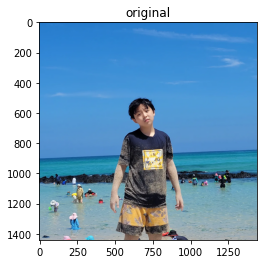

 Segmentation < Object : background, Index : 0 >
 Segmentation < Object : person, Index : 15 >


In [ ]:
img_orig, output = segmatation('3.jpg')

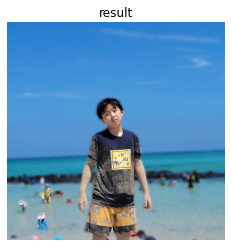

In [ ]:
result1 = mask(15, 20)

# Change Background

In [ ]:
def mask_back(object, blur, back_img):
    # colormap to rgb
    colormap[object]
    seg_color = np.zeros((3,))
    seg_color = seg_color.astype(int)
    for i in range(3):
        idx = 2 - i
        seg_color[idx] = colormap[object][i]

    # gray scale    
    seg_map = np.all(output==seg_color, axis=-1) 
#     plt.imshow(seg_map, cmap='gray')
#     plt.title('gray')
#     plt.show()
    
    # to colormap.jet
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # background
    back_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/'+ back_img  
    back_orig = cv2.imread(back_img_path) 
    back_orig = cv2.resize(back_orig, dsize=(img_orig.shape[1], img_orig.shape[0]))
    plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
    plt.title('backgound')
    plt.show()
    
    # blur
    img_orig_blur = cv2.blur(back_orig, (blur,blur)) # (13,13)은 차이가 없었음.
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.title('blur')
#     plt.show()
    
    # mask
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.title('masked')
#     plt.show()
    
    # focused object + blured background
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title('result')
    plt.axis('OFF')
    plt.show()
    
    return img_concat

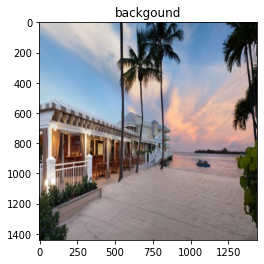

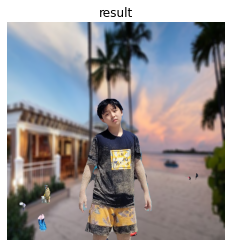

In [ ]:
result2_back = mask_back(15, 20, 'beach-bar.jpg')

# Animal Image

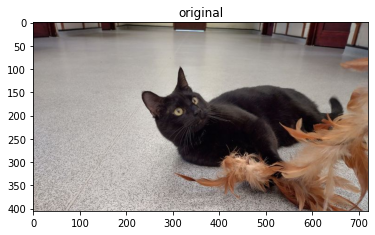

 Segmentation < Object : background, Index : 0 >
 Segmentation < Object : cat, Index : 8 >


In [ ]:
img_orig, output = segmatation('cat.jpg')

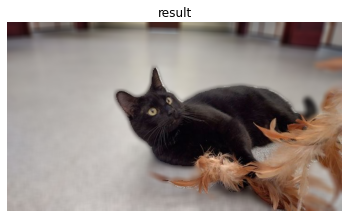

In [ ]:
result_cat = mask(8, 13)
# 고양이와 붙어있는 깃털을 고양이와 함께 분류하였음.

# 2 Focused Objects

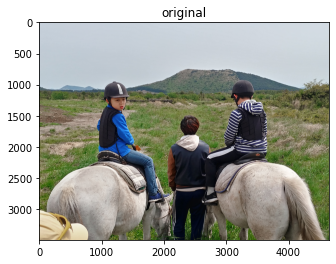

 Segmentation < Object : background, Index : 0 >
 Segmentation < Object : horse, Index : 13 >
 Segmentation < Object : person, Index : 15 >


In [ ]:
img_orig, output = segmatation('6.jpg')
# 얼굴이 안보이는 말을 잘 분류함.

In [ ]:
# 두 사물을 제외하고 배경을 블러 처리해보자
object1=13
object2=15

# colormap to rgb
colormap[object1]
seg_color1 = np.zeros((3,))
seg_color1 = seg_color1.astype(int)
for i in range(3):
    idx = 2 - i
    seg_color1[idx] = colormap[object1][i]

colormap[object2]
seg_color2 = np.zeros((3,))
seg_color2 = seg_color2.astype(int)
for i in range(3):
    idx = 2 - i
    seg_color2[idx] = colormap[object2][i]  


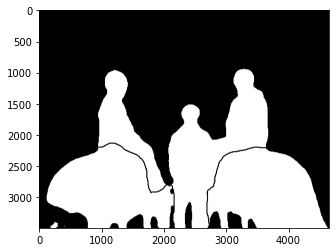

In [ ]:
# gray scale    
seg_map1 = np.all(output==seg_color1, axis=-1) 
seg_map2 = np.all(output==seg_color2, axis=-1)

# 두 seg_map을 더하기
seg_map1_add_map2 = np.where(seg_map1==False, seg_map2, seg_map1)
#     plt.imshow(seg_map, cmap='gray')
#     plt.title('gray')
#     plt.show()

# to colormap.jet
img_mask = seg_map1_add_map2.astype(np.uint8) * 255
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
plt.show()

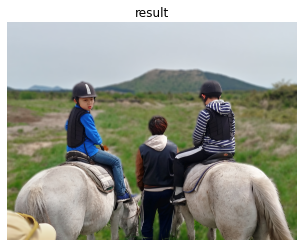

In [ ]:
# blur
img_orig_blur = cv2.blur(img_orig, (40, 40)) # (13,13)은 차이가 없었음.
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.title('blur')
#     plt.show()

# mask
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.title('masked')
#     plt.show()

# focused object + blured background
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('result')
plt.axis('OFF')
plt.show()

## a Person behind Cow

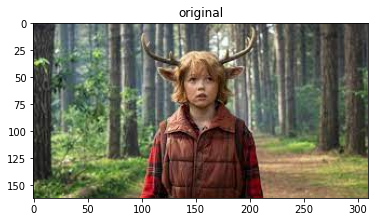

 Segmentation < Object : background, Index : 0 >
 Segmentation < Object : cow, Index : 10 >
 Segmentation < Object : person, Index : 15 >


In [ ]:
img_orig, output = segmatation('4.jpg')
# 분장한 사람을 그대로 눈을 포함하여 뿔을 소로 나머지를 사람으로 분류하였음.

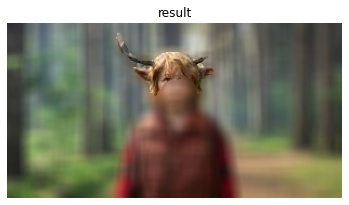

In [ ]:
result_cow = mask(10, 13)

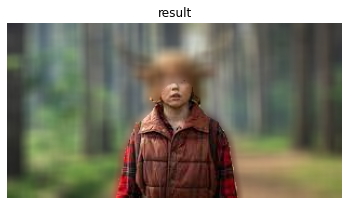

In [ ]:
result_person = mask(15, 13)

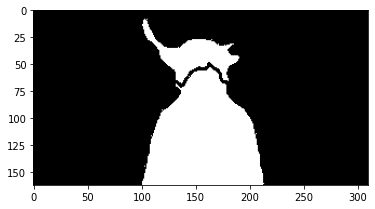

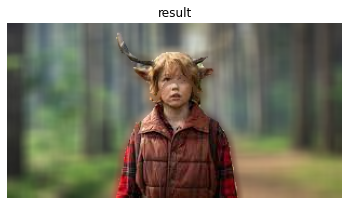

In [ ]:
# 두 사물을 제외하고 배경을 블러 처리해보자
object1=10
object2=15

# colormap to rgb
colormap[object1]
seg_color1 = np.zeros((3,))
seg_color1 = seg_color1.astype(int)
for i in range(3):
    idx = 2 - i
    seg_color1[idx] = colormap[object1][i]

colormap[object2]
seg_color2 = np.zeros((3,))
seg_color2 = seg_color2.astype(int)
for i in range(3):
    idx = 2 - i
    seg_color2[idx] = colormap[object2][i]  


# gray scale    
seg_map1 = np.all(output==seg_color1, axis=-1) 
seg_map2 = np.all(output==seg_color2, axis=-1)

# 두 seg_map을 더하기
seg_map1_add_map2 = np.where(seg_map1==False, seg_map2, seg_map1)
#     plt.imshow(seg_map, cmap='gray')
#     plt.title('gray')
#     plt.show()

# to colormap.jet
img_mask = seg_map1_add_map2.astype(np.uint8) * 255
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))
plt.show()

# blur
img_orig_blur = cv2.blur(img_orig, (13, 13)) # (13,13)은 차이가 없었음.
#     plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
#     plt.title('blur')
#     plt.show()

# mask
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.title('masked')
#     plt.show()

# focused object + blured background
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('result')
plt.axis('OFF')
plt.show()

# 오잉! 소와 사람 사이에 경계가 있었다!!

In [ ]:
cv2.imwrite("cow_person.jpg", img_concat)

True

# Text on Image

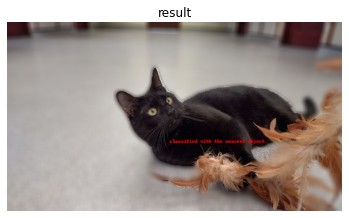

In [ ]:
from PIL import Image, ImageFont

img_pillow = Image.fromarray(result_cat)
draw_text = "classified with the nearest object"


font = ImageFont.load_default()  # 원하는 폰트는 경로 문제로 불러올 수 없었음. 글자 크기를 조절할 수 없었음.
b,g,r,a = 0,0,255,255 # 빨간색 글자
draw = ImageDraw.Draw(img_pillow, 'RGBA')

draw.text((350, 250), draw_text, font=font, fill=(b,g,r,a))
img_numpy = np.array(img_pillow)

# img_pillow

plt.imshow(cv2.cvtColor(img_numpy, cv2.COLOR_BGR2RGB))
plt.title('result')
plt.axis('OFF')
plt.show()

# https://supermemi.tistory.com/entry/Python-PIL-PIL-Image-text-FontImageFont-%EA%B8%80%EC%94%A8-%ED%81%AC%EA%B8%B0-%ED%8F%B0%ED%8A%B8-%EB%B3%80%EA%B2%BD%ED%95%98%EA%B8%B0
# https://bskyvision.com/entry/python-opencv-%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%97%90-%ED%95%9C%EA%B8%80-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%82%BD%EC%9E%85%ED%95%98%EA%B8%B0

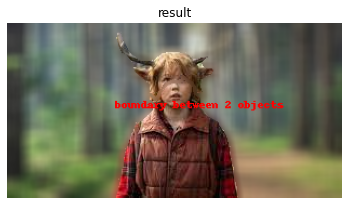

In [ ]:
from PIL import Image, ImageFont

img_pillow = Image.fromarray(img_concat)

# fontpath = "fonts/gulim.ttc"
# font = ImageFont.truetype("arial.ttf", 24)
font = ImageFont.load_default()
b,g,r,a = 0,0,255,255 # 빨간색 글자
draw = ImageDraw.Draw(img_pillow, 'RGBA')
draw.text((100, 70), "boundary between 2 objects", font=font, fill=(b,g,r,a))
img_numpy = np.array(img_pillow)

# img_pillow
plt.imshow(cv2.cvtColor(img_numpy, cv2.COLOR_BGR2RGB))
plt.title('result')
plt.axis('OFF')
plt.show()

# Solution of Problems
- 붙어있는 사물과 같이 분류되는 것. 
    깃털과 고양이는 적외선 카메라로 본다면 온도가 다르게 나올 것이 분명하고 경계가 분명할 것이라 예상됨.  
    적외선 카메라로 찍은 사진을 같이 적용하면 고양이와 깃털을 분류할 수 있을 거라 생각함.

- 한 사물을 둘로 분류하는 경우 경계가 선이 아니라 면이고 그 면은 배경으로 분류함.  
    이 문제도 적외선 카메라로 해결할 수 있을 거 같음.
    적외선 카메라로는 두 개로 분류된 얼굴이 한 객체로 보일 것이기 때문에

# Review
- 이미 학습된 모델을 활용하는 프로젝트였음.
- segmantation의 종류(watershed, semantic, instance)를 알았고 semantic segmentation을 활용하면서 그 문제점을 찾아보았음.
- 2가지 문제를 찾았고 둘의 문제는 적외선 카메라를 같이 사용해 해결할 수 있을 거라 예상함.
- 한 사진에서 두 가지 이상의 객체를 분리한 경우 두 객체를 제외하고 블러 처리를 함. (np.where를 사용)
- 이미지에 글자를 넣을 때 cv2.putText로는 에러가 있었고 해결하지 못하였음.
- 대신 이미지를 pillow 이미지로 변환 후에 글자를 추가할 수 있었음.
- 폰트를 선택할 수 있었지만 경로 문제로 기본으로 제공하는 폰트를 사용하였고 글자 크기를 바꿀 수 없었음.